## 多输入 & 单输出

多输入单输出常见的应用有：
* 1.输入一个照片 & 输入对照片的描述，输出照片的类别或价值。
* 2.输入一个照片 & 输入照片的类别，输出照片的价值。
* 3.输入一段视频 & 输入对视频的描述，输出视频的评价。

其中第一种和第三种比较常见。  
第一种在渔业鱼群跟踪上有很大作用，描述通常为时间、经纬度等信息。  
第三种在短视频分类及风险评估上有极大作用。  

但这里使用第二种作为例子，主要是因为结构简单，可以避免初学者在数据集查找和文件读写上耗费时间。  
Quick Start文件夹下的宗旨在于不让初学者进行额外的数据集下载，尽量使用Keras自带的数据集。  
从我自身的学习经历上来看，很多案例一开始就需要下载各种数据集，然后便是复杂的IO和格式转化等操作，这对初学者而言十分不友好。  

此外，有很多优秀的模型能够快速处理视频信息，不同模型训练耗时和性能可能相差上百倍，这些将在Advance中详细展开。  

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

## 加载数据

In [2]:
(x_train, y_train), (_, _) = mnist.load_data()

worth_train = np.array([5 if x>4 else 2 for x in y_train])     # 当标签值大于4认为有价值为5，否则价值为2
x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes=10)

这里之所以不将价值用 0 1 划分是因为价值问题本质是回归问题，如果用 0 1 划分价值容易让初学者以为分类问题。  
尽管在Qucik Start上不要求初学者掌握特别高深的技巧，但至少要清楚分类问题和回顾问题的区别。  

## 构架模型

In [3]:
image_input = Input(shape=(28, 28, 1), name='image_input')
label_input = Input(shape=(10,), name='label_input')

# 标签全连接
dense_1 = Dense(16, activation='relu')(label_input)
dense_2 = Dense(16, activation='relu')(dense_1)

# 图像卷积部分
conv_1 = Conv2D(32, 3, padding='same', activation='relu')(image_input)
conv_2 = Conv2D(64, 3, padding='same', activation='relu')(conv_1)
maxp_1 = MaxPooling2D()(conv_2)

conv_3 = Conv2D(64, 3, padding='same', activation='relu')(maxp_1)
conv_4 = Conv2D(32, 3, padding='same', activation='relu')(conv_3)
maxp_2 = MaxPooling2D()(conv_4)

conv_5 = Conv2D(32, 3, padding='same', activation='relu')(maxp_2)
conv_6 = Conv2D(16, 3, padding='same', activation='relu')(conv_5)
maxp_3 = MaxPooling2D()(conv_6)

concate_layer = multiply([dense_2, maxp_3])

flatten = Flatten()(concate_layer)
dense_out = Dense(16, activation='relu')(flatten)
dense_out = Dense(1, activation='relu')(dense_out)

In [4]:
model = Model(inputs=[image_input, label_input], outputs=dense_out)

## 编译模型

In [5]:
model.compile(loss='mae', optimizer='adam')

因为是回归问题，所以损失函数应该是误差类的而不是熵类，具体可以在 Help Manule 中查看常见的损失函数

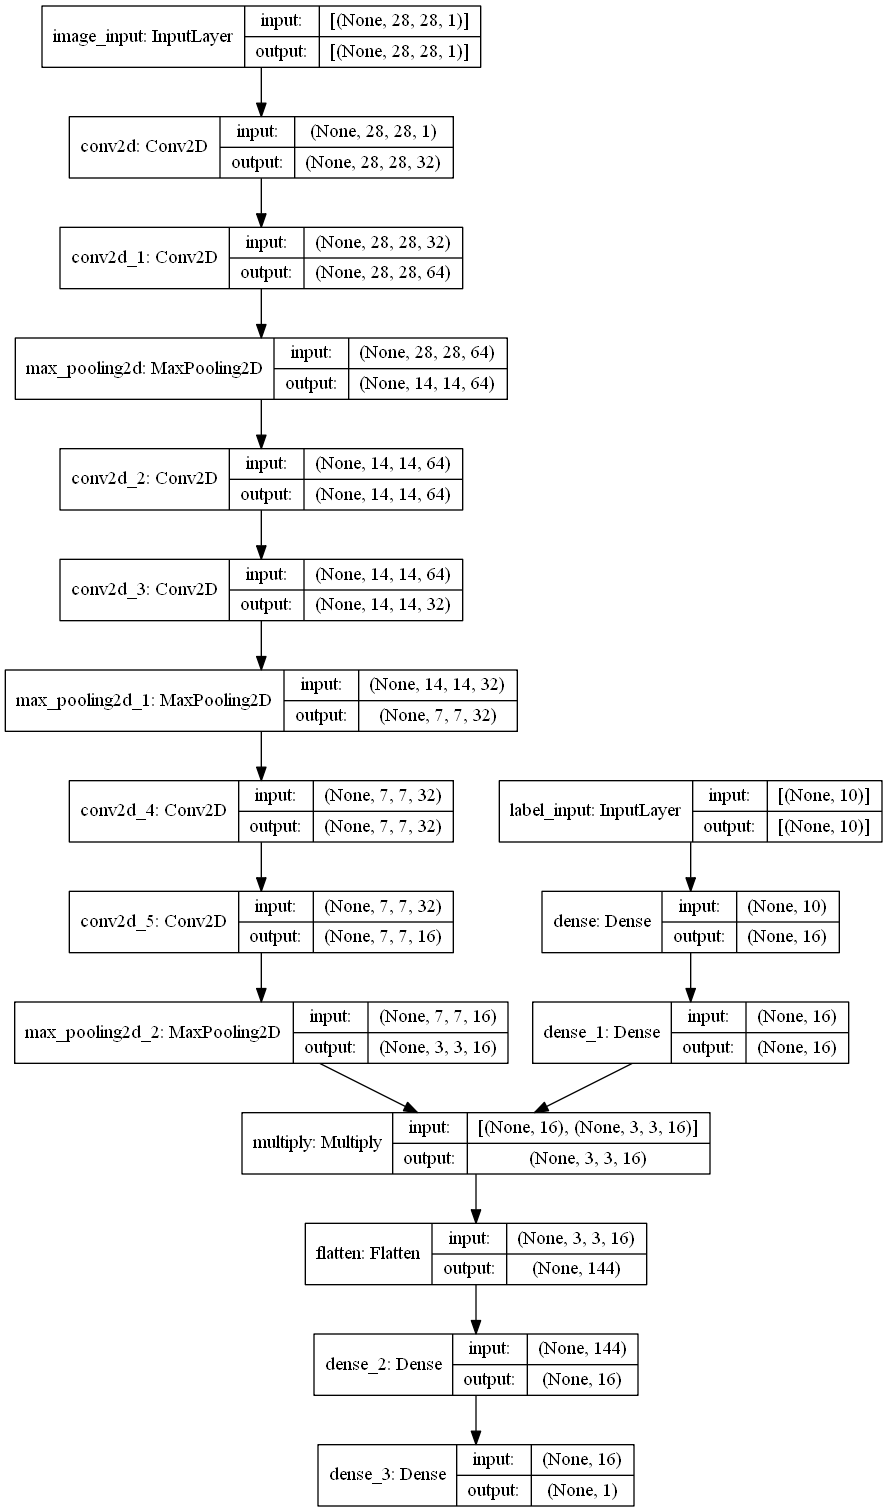

In [6]:
plot_model(model, show_shapes=True)

## 训练模型

In [7]:
model.fit(
    {'image_input': x_train, 'label_input':y_train},
    worth_train,
    epochs=5,
    batch_size=512,
    verbose=1
)

Epoch 1/5
118/118 [==============================] - 11s 69ms/step - loss: 1.6877
Epoch 2/5
118/118 [==============================] - 8s 66ms/step - loss: 0.1772
Epoch 3/5
118/118 [==============================] - 8s 66ms/step - loss: 0.0875
Epoch 4/5
118/118 [==============================] - 8s 65ms/step - loss: 0.1231
Epoch 5/5
118/118 [==============================] - 8s 65ms/step - loss: 0.0874


## 检查

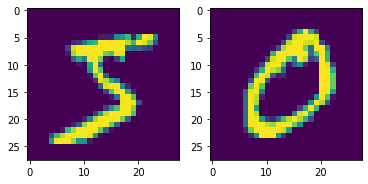

In [8]:
plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.subplot(1,2,2)
plt.imshow(x_train[1])

In [9]:
worth_train[0], worth_train[1]

(5, 2)

第一张图是 5，第二张图是 0；  
那么，根据之前定的规矩，第一张图的价值为 5，第二章图的价值为 2

In [10]:
score_1 = model.predict([x_train[0:1], y_train[0:1]])
score_2 = model.predict([x_train[1:2], y_train[1:2]])

In [11]:
score_1, score_2

(array([[4.9015384]], dtype=float32), array([[1.9697405]], dtype=float32))

从结果来看：  
模型认为第一张图价值为 4.9015384；  
模型认为第一张图价值为 1.9697405；